In [72]:
from imageio import imread
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category = ConvergenceWarning)

np.random.seed(2018)

C:\Users\sanfe\AppData\Local\Temp\ipykernel_23276\787212928.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  terrain1 = imread('SRTM_data_Norway_1.tif')


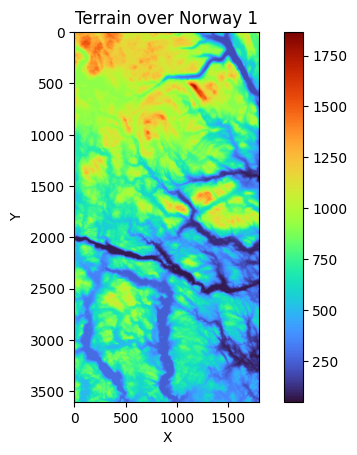

In [2]:
# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')

# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap = "turbo")
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
plt.savefig("Terrain_data.png")
plt.show()

In [3]:
terrain1.shape

(3601, 1801)

The dataset is a grid of dimension 3601x1801.

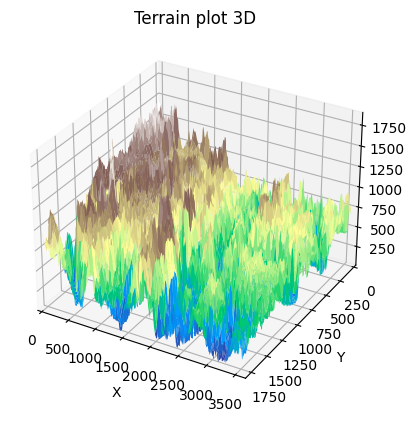

In [4]:
# Represent the entire dataset in a 3D plot, with colors according to the height of the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y = np.meshgrid(range(3601), range(1801))
surf = ax.plot_surface(x.T, y.T, terrain1, cmap = "terrain")
ax.set_xlim(0, 3601)
ax.set_ylim(1801, 0)
plt.title("Terrain plot 3D")
plt.savefig("Terrain_plot_3D.png")
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [5]:
#create design matrix (credits: M. Hjorth-Jensen: Weekly Material, Week 35)
def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

# Define a function for Mean Square Error
def MSE(y_data, y_model):
	n = np.size(y_model)
	y_data = y_data.reshape(-1,1)
	y_model = y_model.reshape(-1,1)
	return np.sum((y_data - y_model)**2)/n

# Define a function for R2
def rsquare(y, ypredict):
	ypredict = ypredict.reshape(-1,1)
	return 1-(np.sum((y-ypredict)**2)/np.sum((y-np.mean(y))**2))

# Define a function which applies min-mas scaling
def min_max_scaling(x):
    return (x-min(x))/(max(x)-min(x))

In order to avoid the complications related to the problem of dealing with a high number of data, we considered it useful to reduce the number of points to take into consideration in the analysis by selecting randomly 1500 points from the available data. Afterwards, both the inputs and the output have been scaled using min-max scaling. We decided to apply min-max scaling in order to transform all of our data into values between 0 and 1. In this way, all the data that we have can be compared without problems of any kind.

In [6]:
# Select at random 1500 points from the entire set of points (beacsue there are too many points and otherwise the models will be very slow)
num_points = 1500
points = np.zeros([num_points, 2])
points = np.column_stack((np.random.randint(0, terrain1.shape[0], size = 1500), np.random.randint(0, terrain1.shape[1], size = 1500)))

# The z vector contains only the values relative to the 1500 randomly selected point
z = np.zeros([num_points, 1])
for i in range(num_points):
    z[i] = terrain1[int(points[i,0])][int(points[i,1])]

# Scale the data
z = min_max_scaling(z)
points = np.column_stack((min_max_scaling(points[:,0]), min_max_scaling(points[:,1])))

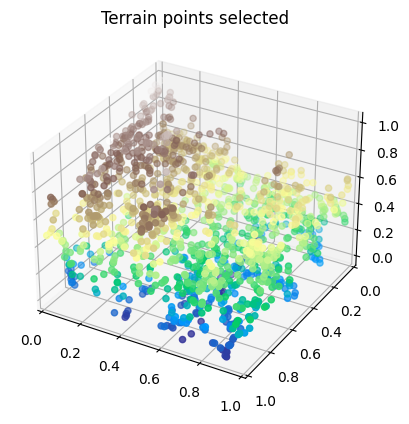

In [7]:
# Represent the selected points into a 3D scatterplot
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
x, y = np.meshgrid(range(3601), range(1801))
ax.scatter(points[:,0], points[:,1], z, cmap = "terrain", c = z) # Create a scatterplot with colors according to the height of the point
plt.title("Terrain points selected")
ax.set_xlim(0, 1)
ax.set_ylim(1, 0)
plt.savefig("Terrain_points_selected.png")
plt.show()

**OLS**

In [8]:
maxdegree = 20

# Create the design matrix
X = create_X(points[:, 0], points[:, 1], maxdegree)

# Removing the intercept column
X = X[:, 1:]

# Split in train and test data
x_train, x_test, z_train, z_test = train_test_split(X, z, test_size = 0.2)

In [31]:
def cross_validation(X, z, model, n):
    num_folds = n
    kf = KFold(n_splits = num_folds, shuffle = True, random_state = 42)

    train_mse_cv = np.zeros((maxdegree, num_folds))
    test_mse_cv = np.zeros((maxdegree, num_folds))
    rsqr_train_cv = np.zeros((maxdegree, num_folds))
    rsqr_test_cv = np.zeros((maxdegree, num_folds))

    fold = 0
    for train_idx, test_idx in kf.split(X):
        for deg in range(1, maxdegree):
            c = int((deg + 2) * (deg + 1) / 2)
            X_train_fold, X_test_fold = X[train_idx, :c-1], X[test_idx, :c-1]
            z_train_fold, z_test_fold = z[train_idx], z[test_idx]

            model.fit(X_train_fold, z_train_fold)

            z_train_pred_fold = model.predict(X_train_fold)
            z_test_pred_fold = model.predict(X_test_fold)

            train_mse_cv[deg, fold] = MSE(z_train_fold, z_train_pred_fold)
            test_mse_cv[deg, fold] = MSE(z_test_fold, z_test_pred_fold)
            rsqr_train_cv[deg, fold] = rsquare(z_train_fold, z_train_pred_fold)
            rsqr_test_cv[deg, fold] = rsquare(z_test_fold, z_test_pred_fold)

        fold += 1

    mean_train_mse_cv = np.mean(train_mse_cv, axis=1)
    mean_test_mse_cv = np.mean(test_mse_cv, axis=1)

    mean_rsqr_train_cv = np.mean(rsqr_train_cv, axis=1)
    mean_rsqr_test_cv = np.mean(rsqr_test_cv, axis=1)
    return mean_train_mse_cv, mean_test_mse_cv, mean_rsqr_train_cv, mean_rsqr_test_cv

In [32]:
train_mse_OLS, test_mse_OLS, train_rsqr_OLS, test_rsqr_OLS = cross_validation(X, z, LinearRegression(), 5)

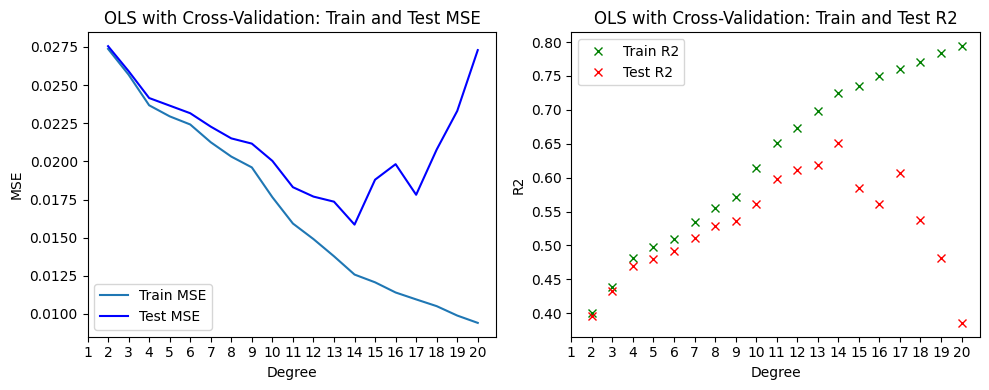

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].errorbar(range(2, maxdegree + 1), train_mse_OLS[1:], label="Train MSE")
axs[0].errorbar(range(2, maxdegree + 1), test_mse_OLS[1:], color='b', label="Test MSE")
axs[0].set_xlabel('Degree')
axs[0].set_ylabel('MSE')
axs[0].set_xticks(ticks=range(1, maxdegree + 1))
axs[0].set_title('OLS: Train and Test MSE')
axs[0].legend()

axs[1].errorbar(range(2, maxdegree + 1), train_rsqr_OLS[1:], fmt='gx', label='Train R2')
axs[1].errorbar(range(2, maxdegree + 1), test_rsqr_OLS[1:], fmt='rx', label='Test R2')
axs[1].set_xlabel('Degree')
axs[1].set_ylabel('R2')
axs[1].set_title('OLS: Train and Test R2')
axs[1].set_xticks(ticks=range(1, maxdegree + 1))
axs[1].legend()

plt.tight_layout()
plt.show()


We can observe that the test error is higher than the train error for higher complexities. The positive aspect is that, up to degree 16, both train and test error have a decreasing trend, thus confirming that complexity reduces the MSEs. From degree 14, while the train error keeps getting better and better, the test error start to become worse than before. This is due to the phenomenon of overfitting: since the model with high complexity is constructed to perform very well with the test data, when it deals with a new sample of points (the test sample), its performance accuracy is reduced. 

On the contrary, looking at the $R^2$ plot, the values for the train set are worse than the ones of the test set for degrees lower than or equal to 13. Then, from degree 14, the train coefficient start to increase in a very good trend, but at the same time the test coefficient starts decreasing very quickly (reaching low values, even under 0.4). Thus, the phenomenon of overfitting is verified again. 

In [27]:
print("The minimum value of MSE for OLS is registered with a polynomial degree of:")
print(np.argmin(test_mse_OLS[1:])+2)

The minimum value of MSE for OLS is registered with a polynomial degree of:
14


The minimum value of the MSE for the test sample is obtained with a polynomial degree of 14. With this degree, also the train MSE is low. As a consequence, a goot choice is to apply OLS with degree 14. 

**Ridge**

The second step consists in applying Ridge Regression: the model has been applied with different values of $\lambda$, but also with different polynomial degrees. 

In [67]:
# Set the values of lambda
nlambdas = 100
lambdas = np.logspace(-5, 5, nlambdas)

# Create arrays to store the results of cross-validation
train_mse_Ridge = np.zeros((nlambdas, maxdegree))
test_mse_Ridge = np.zeros((nlambdas, maxdegree))
train_rsqr_Ridge = np.zeros((nlambdas, maxdegree))
test_rsqr_Ridge = np.zeros((nlambdas, maxdegree))

# Apply ridge for every combination of polynomial degree and lambda
for j in range(nlambdas):
    for i in range(1, maxdegree + 1):
        c = int((i + 2) * (i + 1) / 2)
        X_tilde = X[:, :c-1]

        Ridge = linear_model.Ridge(lambdas[j], max_iter = 200)
        
        # Perform cross-validation for Ridge regression
        train_mse, test_mse, train_rsqr, test_rsqr = cross_validation(X_tilde, z, Ridge, n = 5)

        # Store the results in the arrays
        train_mse_Ridge[j, i-1] = np.mean(train_mse)
        test_mse_Ridge[j, i-1] = np.mean(test_mse)
        train_rsqr_Ridge[j, i-1] = np.mean(train_rsqr)
        test_rsqr_Ridge[j, i-1] = np.mean(test_rsqr)

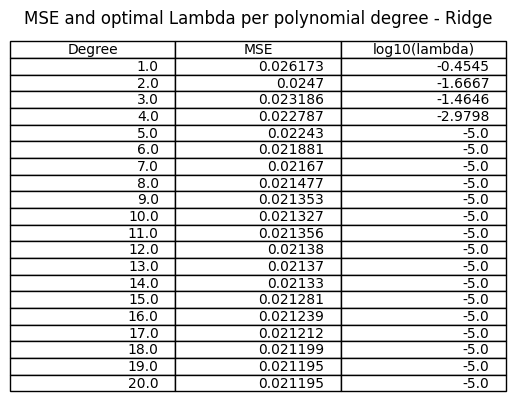

In [68]:
MSE_Ridge_df = pd.DataFrame(test_mse_Ridge, index = lambdas, columns = range(1, maxdegree+1))
MSE_Ridge_df = MSE_Ridge_df.T

# Create new columns "MSE" and "lambda" containing the minimum value for each row and the lambda value respectively
MSE_Ridge_df[["MSE", "log10(lambda)"]] = MSE_Ridge_df.apply(lambda row: pd.Series([round(row.min(), 6), round(np.log10(row.idxmin()), 4)]), axis=1)

# Drop the original columns to keep only MSE and lambda columns
MSE_Ridge_df.drop(MSE_Ridge_df.columns.difference(["MSE", "log10(lambda)"]), axis=1, inplace=True)

MSE_Ridge_df["Degree"] = MSE_Ridge_df.index
MSE_Ridge_df = MSE_Ridge_df[["Degree", "MSE", "log10(lambda)"]]

# Save the table
fig, ax = plt.subplots(1, 1)
ax.axis('off')
ax.axis('tight')
ax.table(cellText = MSE_Ridge_df.values, colLabels = MSE_Ridge_df.columns, loc = 'center')
ax.set_title("MSE and optimal Lambda per polynomial degree - Ridge")
plt.savefig("Ridge_table.png")
plt.show()

In [69]:
print("Lambda 1:", lambdas[0])
print("Lambda 2:", lambdas[49])

Lambda 1: 1e-05
Lambda 2: 0.8902150854450392


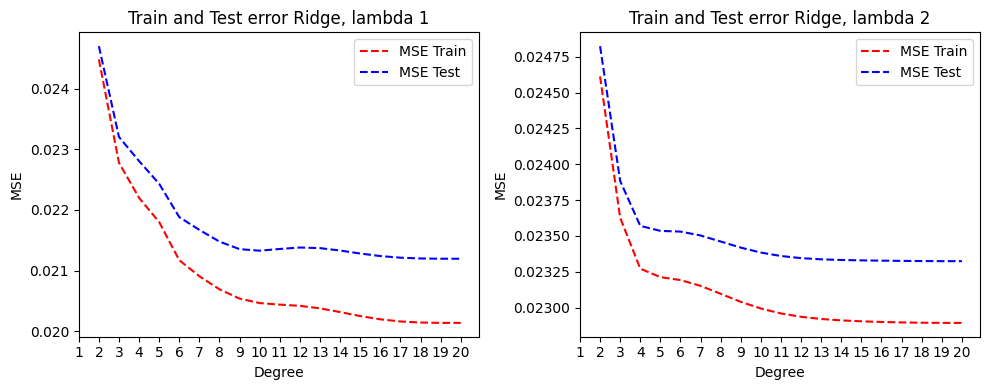

In [70]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))  

# Plot for lambda = 1e-05
axs[0].plot(range(2, maxdegree + 1), train_mse_Ridge[0][1:], 'r--', label='MSE Train')
axs[0].plot(range(2, maxdegree + 1), test_mse_Ridge[0][1:], 'b--', label='MSE Test')
axs[0].set_xlabel('Degree')
axs[0].set_ylabel('MSE')
axs[0].set_xticks(ticks = range(1, maxdegree + 1))
axs[0].set_title('Train and Test error Ridge, lambda 1')
axs[0].legend()

# Plot for lambda = 0.8902150854450392
axs[1].plot(range(2, maxdegree + 1), train_mse_Ridge[49][1:], 'r--', label='MSE Train')
axs[1].plot(range(2, maxdegree + 1), test_mse_Ridge[49][1:], 'b--', label='MSE Test')
axs[1].set_xlabel('Degree')
axs[1].set_ylabel('MSE')
axs[1].set_title('Train and Test error Ridge, lambda 2')
axs[1].set_xticks(ticks = range(1, maxdegree + 1))
axs[1].legend()

plt.tight_layout()
plt.savefig("Ridge_lambda_comparison.png")

# Show the figure
plt.show()

The above table shows the values of $log_{10}(\lambda)$ that minimize the test MSE for each polynomial degree, together with the correspondent MSE value. We can show the plots for some values of lambda. Even in this case, as for OLS, when the model complexity increases, the MSE tends to decrease. The optimal values of MSE are obtained with different values of $\lambda$, meaning that for each degree we have a different $\lambda$ which allows to minimize the MSE.

**Lasso**

The next step consists in applying Lasso Regression: the model has been applied with different values of $\lambda$, but also with different polynomial degrees. 

In [73]:
# Set the values of lambda
nlambdas = 100
lambdas = np.logspace(-5, 5, nlambdas)

# Create arrays to store the results of cross-validation
train_mse_Lasso = np.zeros((nlambdas, maxdegree))
test_mse_Lasso = np.zeros((nlambdas, maxdegree))
train_rsqr_Lasso = np.zeros((nlambdas, maxdegree))
test_rsqr_Lasso = np.zeros((nlambdas, maxdegree))

# Apply ridge for every combination of polynomial degree and lambda
for j in range(nlambdas):
    for i in range(1, maxdegree + 1):
        c = int((i + 2) * (i + 1) / 2)
        X_tilde = X[:, :c-1]

        Ridge = linear_model.Lasso(lambdas[j], max_iter = 200)
        
        # Perform cross-validation for Ridge regression
        train_mse, test_mse, train_rsqr, test_rsqr = cross_validation(X_tilde, z, Ridge, n = 5)
        
        # Store the results in the arrays
        train_mse_Lasso[j, i-1] = np.mean(train_mse)
        test_mse_Lasso[j, i-1] = np.mean(test_mse)
        train_rsqr_Lasso[j, i-1] = np.mean(train_rsqr)
        test_rsqr_Lasso[j, i-1] = np.mean(test_rsqr)

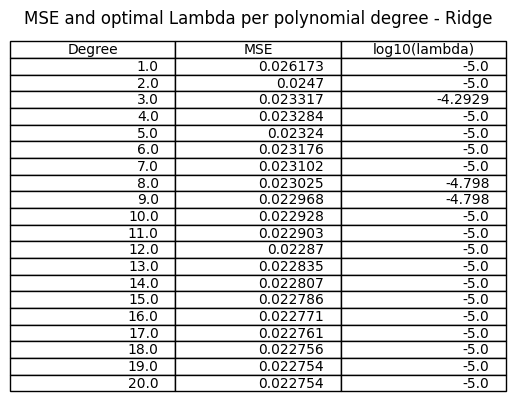

In [74]:
MSE_Ridge_df = pd.DataFrame(test_mse_Lasso, index = lambdas, columns = range(1, maxdegree+1))
MSE_Ridge_df = MSE_Ridge_df.T

# Create new columns "MSE" and "lambda" containing the minimum value for each row and the lambda value respectively
MSE_Ridge_df[["MSE", "log10(lambda)"]] = MSE_Ridge_df.apply(lambda row: pd.Series([round(row.min(), 6), round(np.log10(row.idxmin()), 4)]), axis=1)

# Drop the original columns to keep only MSE and lambda columns
MSE_Ridge_df.drop(MSE_Ridge_df.columns.difference(["MSE", "log10(lambda)"]), axis=1, inplace=True)

MSE_Ridge_df["Degree"] = MSE_Ridge_df.index
MSE_Ridge_df = MSE_Ridge_df[["Degree", "MSE", "log10(lambda)"]]

# Save the table
fig, ax = plt.subplots(1, 1)
ax.axis('off')
ax.axis('tight')
ax.table(cellText = MSE_Ridge_df.values, colLabels = MSE_Ridge_df.columns, loc = 'center')
ax.set_title("MSE and optimal Lambda per polynomial degree - Ridge")
plt.savefig("Ridge_table.png")
plt.show()

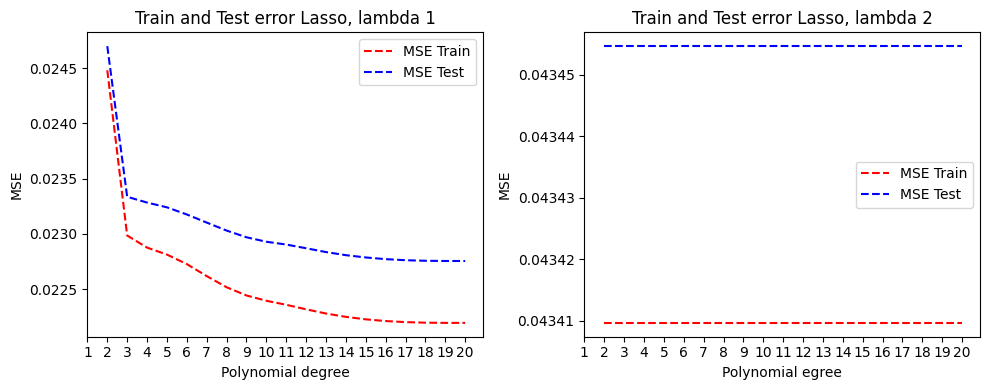

In [75]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4)) 

# Plot for lambda = 1e-05
axs[0].plot(range(2, maxdegree + 1), train_mse_Lasso[0][1:], 'r--', label='MSE Train')
axs[0].plot(range(2, maxdegree + 1), test_mse_Lasso[0][1:], 'b--', label='MSE Test')
axs[0].set_xlabel('Polynomial degree')
axs[0].set_ylabel('MSE')
axs[0].set_xticks(ticks = range(1, maxdegree + 1))
axs[0].set_title('Train and Test error Lasso, lambda 1')
axs[0].legend()

# Plot for lambda = 93.26033468832199
axs[1].plot(range(2, maxdegree + 1), train_mse_Lasso[49][1:], 'r--', label='MSE Train')
axs[1].plot(range(2, maxdegree + 1), test_mse_Lasso[49][1:], 'b--', label='MSE Test')
axs[1].set_xlabel('Polynomial egree')
axs[1].set_ylabel('MSE')
axs[1].set_title('Train and Test error Lasso, lambda 2')
axs[1].set_xticks(ticks = range(1, maxdegree + 1))
axs[1].legend()

plt.tight_layout()
plt.savefig("Ridge_lambda_comparison.png")

# Show the figure
plt.show()

As for Ridge Regression, for Lasso Regression we created a table to compare the values of lambda minimizing the MSE for each polynomial degree. As we can see from the figure, the majority of the best values of MSE are given by the same value of $\lambda$: $\lambda = 0.0001$. In general, we can notice that the MSE is larger than in the previous case, meaning that Lasso is not working very good with our data.

**Comparison**

Finally, we can make a comparison between the three methods. We decided to evaluate their performance with a polynomial degree equal to 16 (which was the optimal value in OLS). 

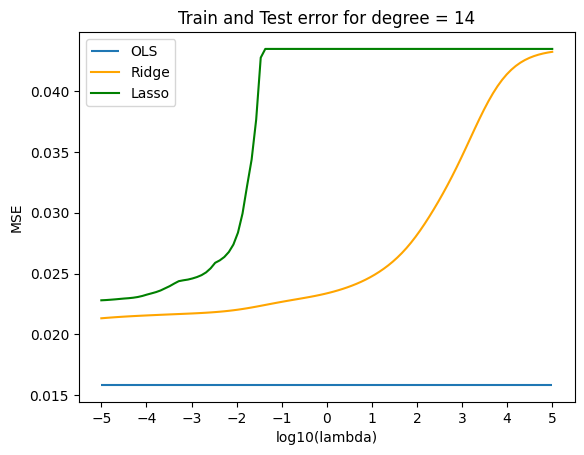

In [77]:
degree = 14

plt.figure()
plt.hlines(test_mse_OLS[13], -5, 5, label = 'OLS')
plt.plot(np.log10(lambdas), test_mse_Ridge[:, 13], 'orange', label = 'Ridge')
plt.plot(np.log10(lambdas), test_mse_Lasso[:, 13], 'green', label = 'Lasso')
plt.xlabel('log10(lambda)')
plt.xticks(ticks = range(-5,6))
plt.ylabel('MSE')
plt.title('Train and Test error for degree = 14')
plt.legend()
plt.savefig("Train and Test error for degree = 14.png")
plt.show()

Bias-Variance tradeoff

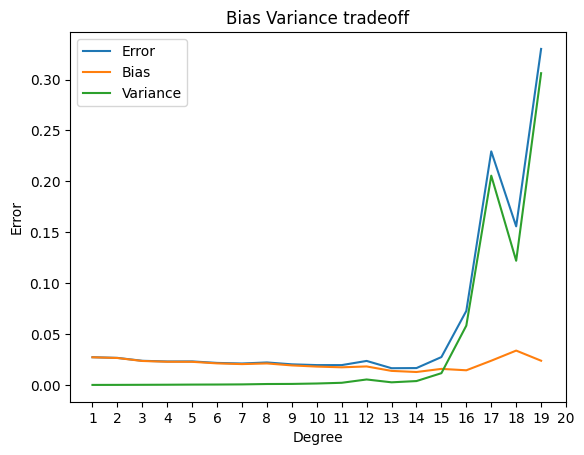

In [1082]:
n_boostraps = 100
z_pred = np.empty((len(z_test), n_boostraps))

maxdegree = 20

error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)

for degree in range(1, maxdegree+1):
    model = LinearRegression(fit_intercept = True)
    y_pred = np.empty((z_test.shape[0], n_boostraps))
    c = int((degree+2)*(degree+1)/2)
    X_tilde = x_train[:, 0:c-1]
    for i in range(n_boostraps):
        x_, y_ = resample(X_tilde, z_train)
        y_pred[:, i] = model.fit(x_, y_).predict(x_test[:, 0:c-1]).ravel()

    polydegree[degree] = degree
    error[degree] = np.mean( np.mean((z_test - y_pred)**2, axis = 1, keepdims = True) )
    bias[degree] = np.mean( (z_test - np.mean(y_pred, axis = 1, keepdims = True))**2 )
    variance[degree] = np.mean( np.var(y_pred, axis = 1, keepdims = True) )

plt.plot(polydegree[1:], error[1:], label = 'Error')
plt.plot(polydegree[1:], bias[1:], label = 'Bias')
plt.plot(polydegree[1:], variance[1:], label = 'Variance')
plt.xticks(ticks = range(1,maxdegree+1))
plt.legend()
plt.xlabel("Polynomial degree")
plt.ylabel("Error")
plt.title("Bias Variance tradeoff")
plt.savefig("Bias_Variance_tradeoff")
plt.show()

The phenomenon of overfitting can be further analyzed by studying the decomposition of the MSE into Bias and Variance. The above figure shows exactly what we want to depict: the so-called Bias-Variance tradeoff. The idea is that, as the complexity of the model increases (i.e as the polynomial degree increases), the variance of the model, starting from very low values, increases sharply. This worsening in variance, particularly visible for the highest degrees, is due again to the overfitting problem. While the Bias is more or less stable, the variance is largely affected by a too close adaption of the model to the training set. As a consequence, even small changes in the data will bring significant changes to the model for large polynomial degrees.

Focusing on the left part of the plot, with small polynomial degrees, we can notice that the vaiance is equal to 0 (until degree = 11), while the bias is a bit higher. Here the only the bias gives a contribution to the error, meaning that we are "underfitting" our model. 

The turning point, where the overfitting phenomenon arises is around degree 14/15. This confirms what has been seen in the previous plot: the test MSE started to get worse around the same degree.  